# Type 1 error example
This notebook is going to explore any mistaken research conclusions that may arise from use of the original Rachlin discount function, and compare that to the Modified Rachlin function.

We will do this in the context of comparing two groups with _the same_ discount rates, $\kappa$. We will explore a range of true differences in $s$ between the groups. 

Note: for this work we focus on the simplified (best) case scenario where there is no measurement error in participant parameter values. We want to seperate issues of parameter recovery from reliability of research conclusion issues. Therefore these results represent the best case scenario.

That the Bayesian t-test component of this code was inspired by the PyMC3 implementation (here https://github.com/strawlab/best, https://docs.pymc.io/notebooks/BEST.html) of the BEST model by Kruschke (2012).

In [1]:
# useful for when updating external .py files
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
import math
import pandas as pd

import pymc3 as pm
print(f'PyMC3 v{pm.__version__}')

%run set_plot_options.py
from bayesian_t_test import make_unequal_variance_model

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


PyMC3 v3.7


In [3]:
# Initialize random number generator
SEED = 123
np.random.seed(SEED)

# Define sampler options
sample_options = {'tune': 1000, 'draws': 2000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

## Functions for simulated dataset generation

In [4]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [5]:
def make_dataset(Δlog_s,
                 logκmean=-3, logκ_std=0.2,
                 logsmean=0, logs_std=0.4,
                 N_per_group=10):
    '''Generate a set of true participant discount function parameter
    values which conforms to the inputs:
    - group means
    - effect size'''
    
    # generate log(κ) values
    a_logκ = np.random.normal(loc=logκmean, scale=logκ_std, size=N_per_group)
    b_logκ = np.random.normal(loc=logκmean, scale=logκ_std, size=N_per_group)
    
    # generate log(s) values
    a_logs = np.random.normal(loc=logsmean-Δlog_s, scale=logs_std, size=N_per_group)
    b_logs = np.random.normal(loc=logsmean+Δlog_s, scale=logs_std, size=N_per_group)
    
    # put everything into a dataframe
    dataset = pd.DataFrame()
    dataset['logkappa'] = np.concatenate([a_logκ, b_logκ])
    dataset['logs'] = np.concatenate([a_logs, b_logs])
    dataset['group'] = np.concatenate( (np.zeros(N_per_group), np.ones(N_per_group)))
    # convert to int
    dataset['group'] = np.int_(dataset['group'])
    
    # generate log(k) values, ie k from the original Rachlin discount function. 
    # k = kappa^s
    dataset['logk'] = np.log( np.exp(dataset['logkappa'])**np.exp(dataset['logs']) )
    
    true_logκ_effect_size = cohend(a_logκ, b_logκ)
    true_logs_effect_size = cohend(b_logs, a_logs)
    
    return dataset, true_logκ_effect_size, true_logs_effect_size

Demonstration of the dataset generation.

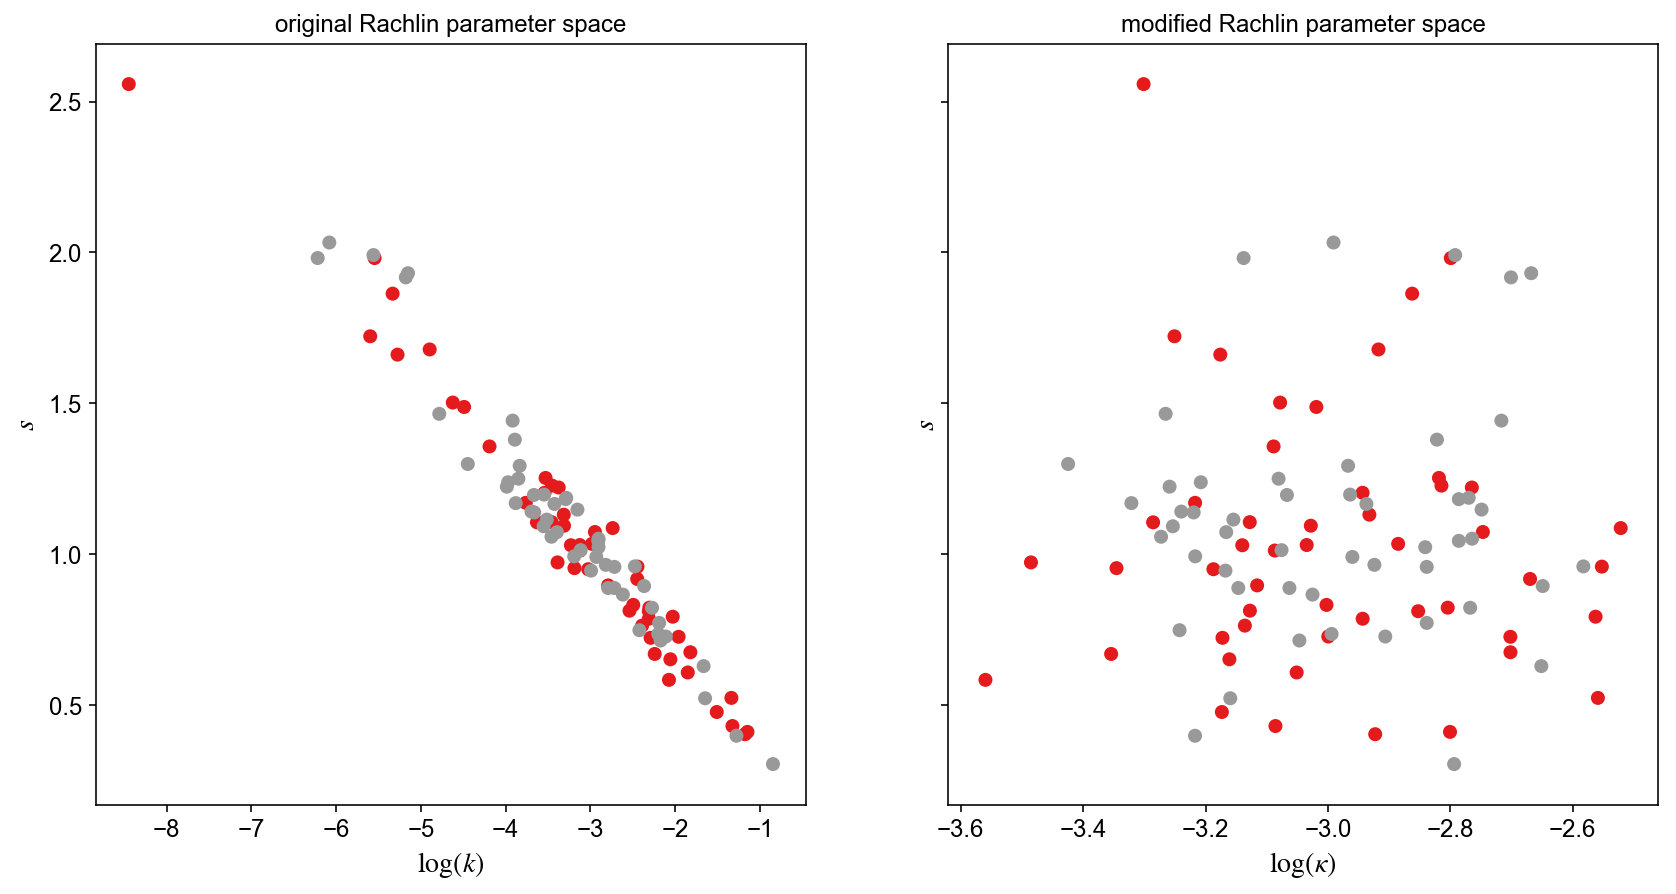

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

Δlog_s = 0.1

dataset, true_logκ_effect_size, true_logs_effect_size = make_dataset(Δlog_s,
                 N_per_group=50)

# plot (kappa, s)
ax[1].scatter(dataset['logkappa'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax[1].set(xlabel='$\log(\kappa)$', ylabel='$s$', title='modified Rachlin parameter space')

# plot (k, s)
ax[0].scatter(dataset['logk'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax[0].set(xlabel='$\log(k)$', ylabel='$s$', title='original Rachlin parameter space');

To summarise, we are creating a distribution of $(\log(\kappa), \log(s))$ values (for 2 groups) in the modified Rachlin parameter space. We are then transforming these into the original Rachlin parameter space $(\log(k), \log(s))$.

We will then proceed to run Bayesian t-tests (unequal variances) on first $\log(\kappa)$ and then on $\log(k)$. This will give us the true effect size (in $\log(\kappa)$) as well as the inferred effect sizes (both for $\log(\kappa)$ and $\log(k)$).

## Sanity check: for a given `group_logκstd` level.

This section is sanity check code, it is not crucial to what comes below.

In [7]:
Δlog_s = 0.1

pdataset, true_logκ_effect_size, true_logs_effect_size = make_dataset(Δlog_s, N_per_group=20)

In [8]:
model = make_unequal_variance_model(pdataset, target_variable='logkappa')

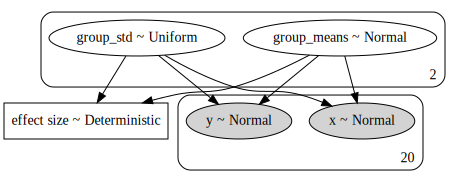

In [9]:
pm.model_to_graphviz(model)

In [10]:
# DO THE INFERENCE
with model:
    trace = pm.sample(**sample_options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4814.11draws/s]


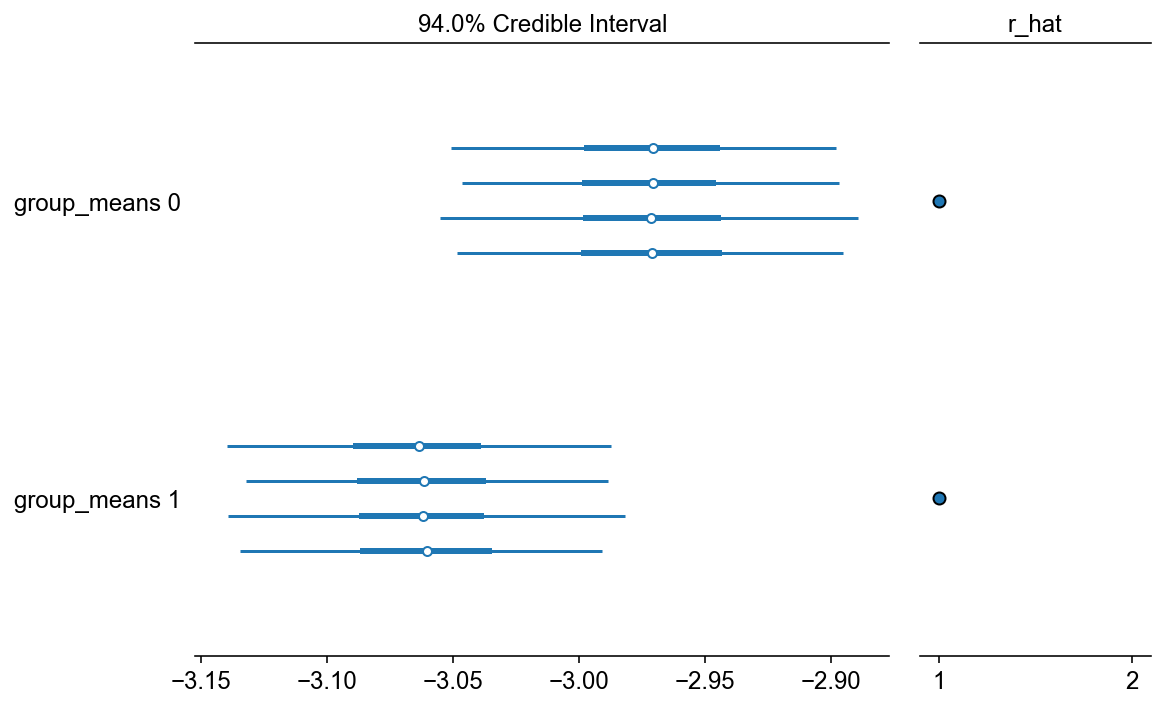

In [11]:
pm.forestplot(trace, var_names=['group_means'], r_hat=True);

In [12]:
true_logs_effect_size

0.23385616937153295

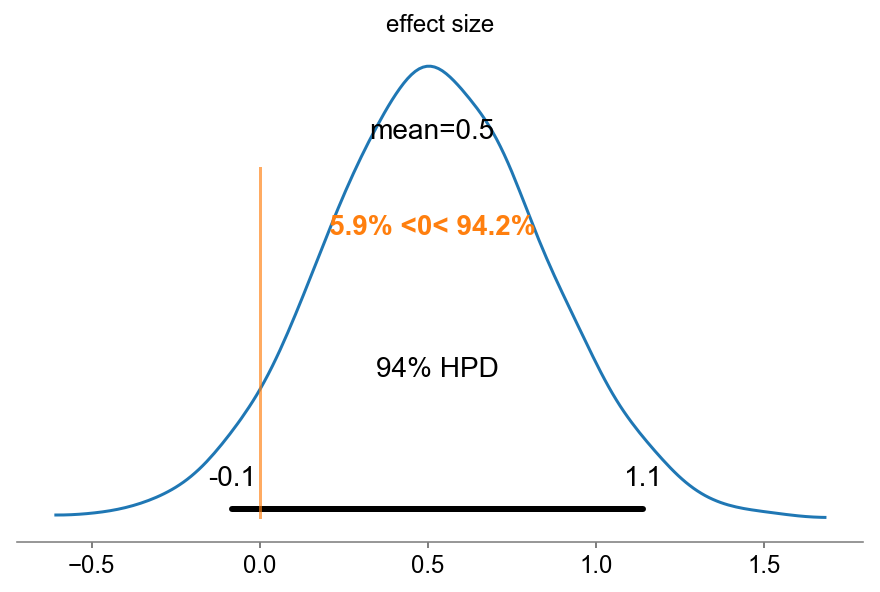

In [13]:
pm.plot_posterior(trace, var_names=['effect size'], ref_val=0, color='#87ceeb');

In [14]:
es_quantiles = pm.stats.quantiles(trace['effect size'])
es_quantiles

{2.5: -0.12024494989905167,
 25: 0.2940307863424393,
 50: 0.5096025563660004,
 75: 0.7270845579390176,
 97.5: 1.1529565767165264}

In [15]:
# print(f'True effect size: {})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4502.55draws/s]


{2.5: -0.4320075853882585,
 25: -0.023141353510930253,
 50: 0.1785211533097677,
 75: 0.3926857751947319,
 97.5: 0.8122094663857043}

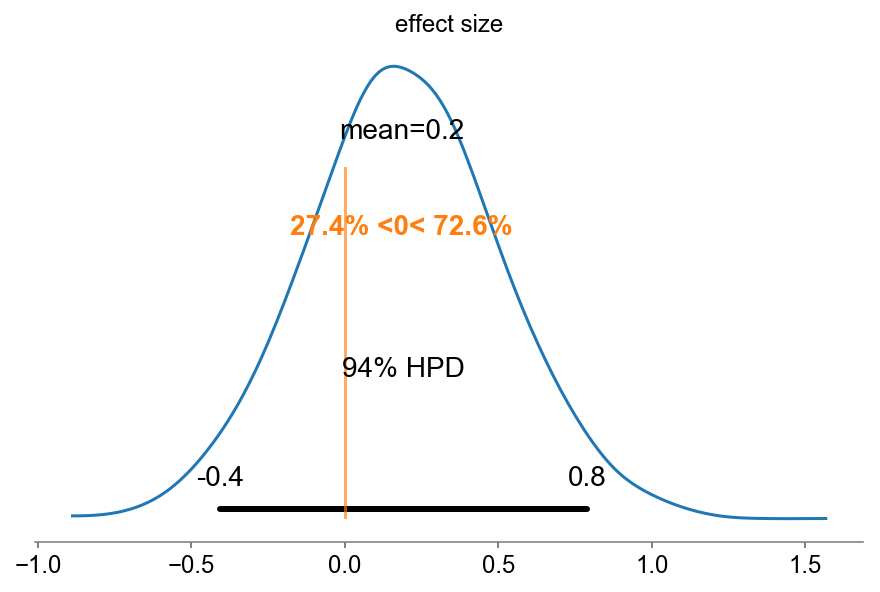

In [16]:
model = make_unequal_variance_model(pdataset, target_variable='logk')

# DO THE INFERENCE
with model:
    trace = pm.sample(**sample_options)
    
pm.plot_posterior(trace, var_names=['effect size'], ref_val=0, color='#87ceeb');

es_quantiles = pm.stats.quantiles(trace['effect size'])
es_quantiles

## Run a sweep over effect sizes
This is our objective - we want to iterate over true effect sizes and plot the inferred effect sizes, for both $\log(\kappa)$ and $\log(k)$.

First we define some functions to do this and plot the results.

In [33]:
def run_effect_size_sweep(Δlog_s_list, **data_kwargs):

    true_logs_effect_size = []

    logκ_inferred_effect_size_median = []
    logκ_inferred_effect_size_lower = []
    logκ_inferred_effect_size_upper = []

    k_inferred_effect_size_median = []
    k_inferred_effect_size_lower = []
    k_inferred_effect_size_upper = []
    

    for Δlog_s in Δlog_s_list:

        print(f'Δlog_s = {Δlog_s}')

        pdataset, true_logκ_es, true_logs_es = make_dataset(Δlog_s, **data_kwargs)

        # inferences about effect size of kappa ----------------

        model_kappa = make_unequal_variance_model(pdataset, target_variable='logkappa')

        with model_kappa:
            trace = pm.sample(**sample_options)

        es_quantiles = pm.stats.quantiles(trace['effect size'])

        true_logs_effect_size.append(true_logs_es)
        logκ_inferred_effect_size_median.append(es_quantiles[50])
        logκ_inferred_effect_size_lower.append(es_quantiles[2.5])
        logκ_inferred_effect_size_upper.append(es_quantiles[97.5])


        # inferences about effect size of k --------------------

        model_k = make_unequal_variance_model(pdataset, target_variable='logk')

        with model_k:
            trace = pm.sample(**sample_options)

        es_quantiles = pm.stats.quantiles(trace['effect size'])

        k_inferred_effect_size_median.append(es_quantiles[50])
        k_inferred_effect_size_lower.append(es_quantiles[2.5])
        k_inferred_effect_size_upper.append(es_quantiles[97.5])


    results = {'logκ': {'true_logs_es': np.array(true_logs_effect_size), 
                        'median': np.array(logκ_inferred_effect_size_median), 
                        'lower': np.array(logκ_inferred_effect_size_lower), 
                        'upper':np.array(logκ_inferred_effect_size_upper)},
               'k': {'median': np.array(k_inferred_effect_size_median), 
                     'lower': np.array(k_inferred_effect_size_lower), 
                     'upper':np.array(k_inferred_effect_size_upper)}}
    
    return results


def plot_results(results, ax):
    
    plt.rcParams.update({'font.size': 16})

    # LOG KAPPA PLOT ------------------------------------------------
    ax.errorbar(results['logκ']['true_logs_es'],
                results['logκ']['median'], 
                yerr=[results['logκ']['lower'] - results['logκ']['median'],
                      results['logκ']['median'] - results['logκ']['upper']], 
                   fmt='-o', 
                   label='modified Rachlin')

    ax.errorbar(results['logκ']['true_logs_es'],
                results['k']['median'], 
                yerr=[results['k']['lower'] - results['k']['median'],
                      results['k']['median'] - results['k']['upper']], 
                   fmt='-o', 
                   label='original Rachlin')

    ax.axhline(y=0, linewidth=1.5, c='k', ls='-', label='true')
    
    ax.plot([0,max(results['logκ']['true_logs_es'])],
            [0,max(results['logκ']['true_logs_es'])],
            linewidth=1.5, c='k', ls='--')

    ax.legend()
        
    max_effect_size = 3
#     ax.plot([0, max_effect_size], [0, max_effect_size], c='k')

    ax.set(xlabel="$\Delta \log(s)$", 
           ylabel="Inferred effect size, Cohen's D", 
           title='log(κ)', ); #ylim=[-1, max_effect_size]

Now we actually run some sweeps over effect size and plot the results.

We do this multiple times, for different degrees of variation in $s$.

In [26]:
# COMPUTE 

Δlog_s_list = np.linspace(0, 0.8, 10)

data_kwargs = {'N_per_group': 40}
    
results = run_effect_size_sweep(Δlog_s_list, **data_kwargs)

Δlog_s = 0.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4641.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4663.40draws/s]


Δlog_s = 0.08888888888888889


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4584.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4780.05draws/s]


Δlog_s = 0.17777777777777778


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4655.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4624.48draws/s]


Δlog_s = 0.26666666666666666


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4653.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4485.18draws/s]


Δlog_s = 0.35555555555555557


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4564.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4635.10draws/s]


Δlog_s = 0.4444444444444445


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4602.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4610.05draws/s]


Δlog_s = 0.5333333333333333


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4685.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4580.25draws/s]


Δlog_s = 0.6222222222222222


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4622.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4530.57draws/s]


Δlog_s = 0.7111111111111111


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4479.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4459.51draws/s]


Δlog_s = 0.8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4560.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_means]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4533.82draws/s]


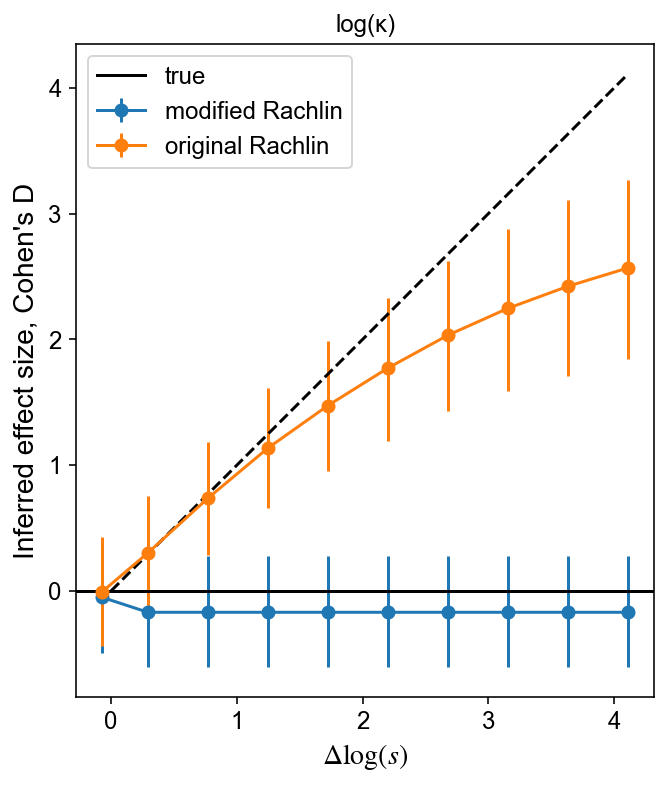

In [34]:
# PLOT
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_results(results, ax)
ax.set_aspect('equal')

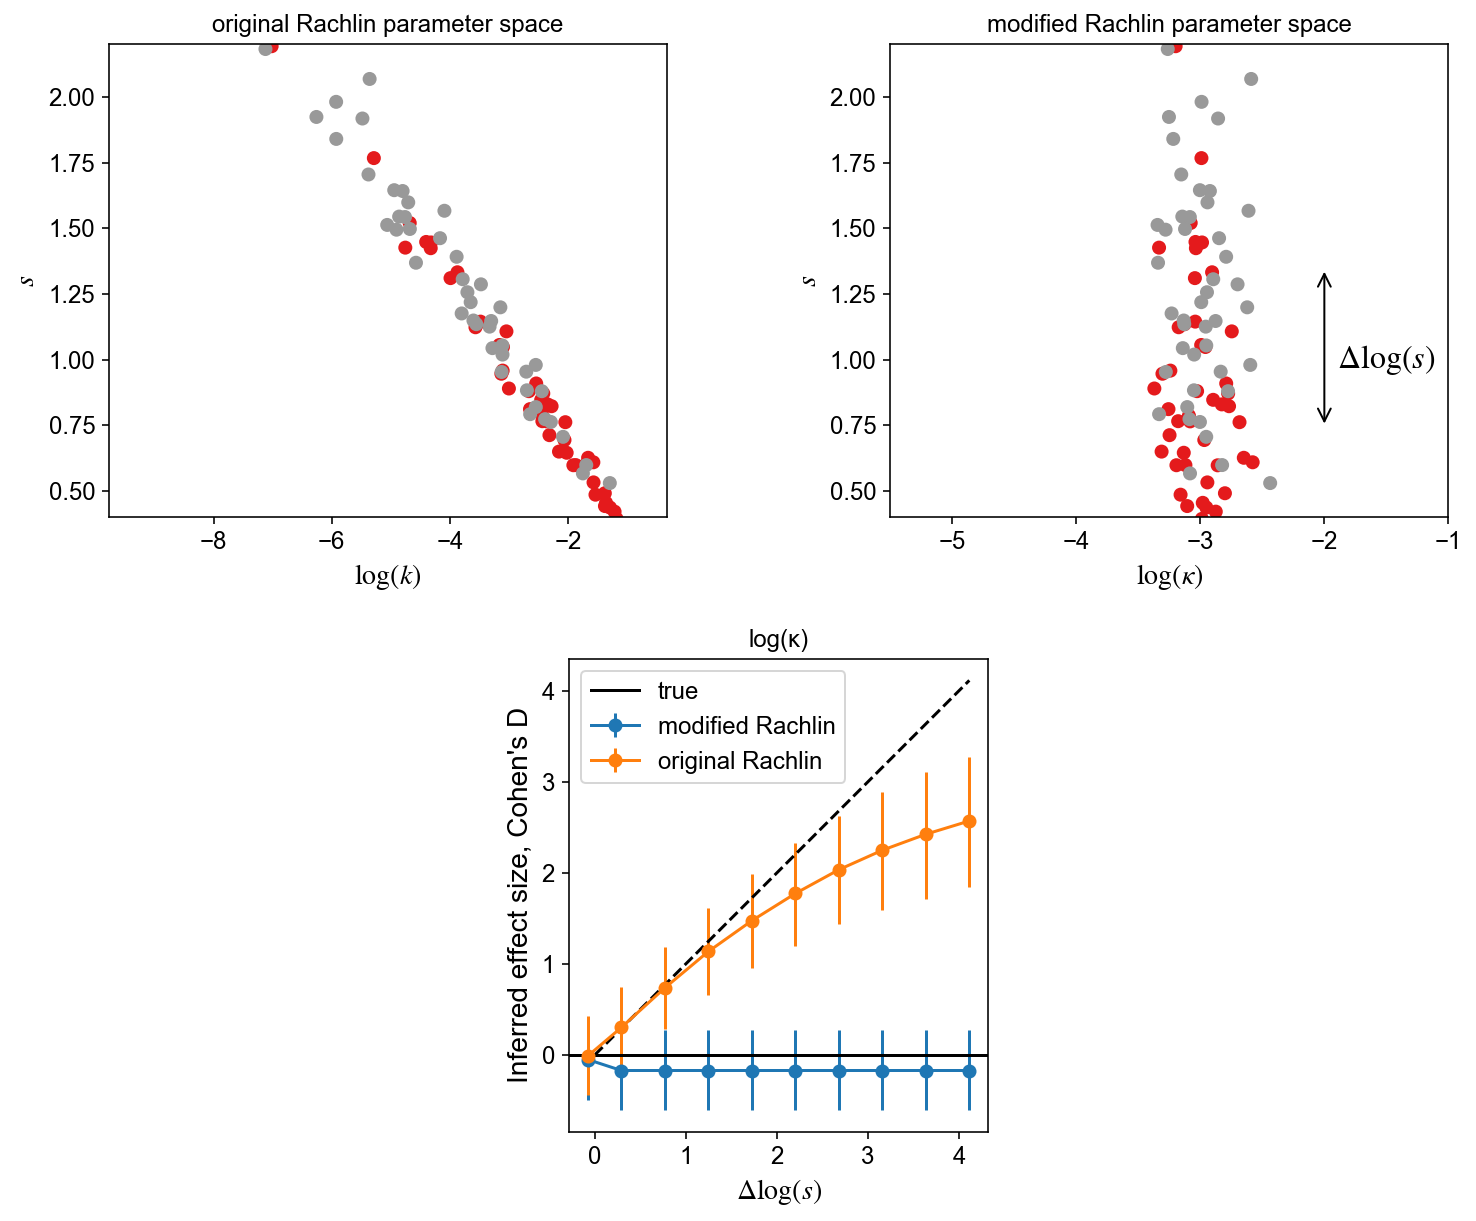

In [36]:
fig = plt.figure(figsize=(12, 10))

# set up subplots
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2, sharey = ax1)

ax = fig.add_subplot(2,1,2)


# PLOT EXAMPLE FIGS =======================================
Δlog_s = 0.3

dataset, true_logκ_effect_size, true_logs_effect_size = make_dataset(Δlog_s, N_per_group=50)

# plot (kappa, s)
ax2.scatter(dataset['logkappa'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax2.set(xlabel='$\log(\kappa)$', ylabel='$s$', title='modified Rachlin parameter space')

# add arrow info
ax2.annotate(
    '', xy=(-2, np.exp(0-Δlog_s)), xycoords='data',
    xytext=(-2, np.exp(0+Δlog_s)), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
ax2.text(-1.9, 1,"$\Delta \log(s)$", verticalalignment='center')

# ax2.annotate(
#     '', xy=(-2.3, 1.9), xycoords='data',
#     xytext=(-4.6, 1.9), textcoords='data',
#     arrowprops={'arrowstyle': '<->'})
# ax2.text(-(2.3 + (4.6-2.3)/2), 2,"$\Delta \log(\kappa)$", horizontalalignment='center')


# plot (k, s)
ax1.scatter(dataset['logk'], np.exp(dataset['logs']), c=dataset['group'], cmap='Set1')
ax1.set(xlabel='$\log(k)$', ylabel='$s$', title='original Rachlin parameter space');

ax2.set(ylim=[0.4, 2.2], xlim=[-5.5, -1])


# PLOT EFFECT SIZE RESULTS ================================
plot_results(results, ax)
# ax.set_title(r'low $\sigma_s$')
# ax.set(xticks=[0, 1, 2, 3], yticks=[0, 1, 2, 3])
ax.set_aspect('equal')

# subplot spacing
plt.subplots_adjust(wspace=0.4, hspace=0.3)

plt.savefig('type_1_error.pdf', bbox_inches='tight')

The inferred effect size for the modified Rachlin function is always good in that it correctly finds no difference in discount rates.

The inferred effect size for the original Rachlin functino is bad in that it incorrectly infers the existance of an effect (of discount rates) when there is none.

# References
- Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.